# Layer structure

<img src="images/layer_structure.png">

### Important: 
* modelB stands for model that uses binary feature labels
* modelC stands for model that uses categorical feature labels

In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Conv2D, Dense, LSTM,MaxPooling2D , Flatten, TimeDistributed,Activation

im_size = 128
time_steps = 16 # len of image sequence
channels = 3
#input_shape=(nr_of_sequences, 16, 227, 227, 3))

#modelB for binary response
modelB = Sequential()
modelB.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
modelB.add(TimeDistributed(Dense(4096)))
modelB.add(LSTM(256, return_sequences=False)) #pole kindel return_sequence's, kui True, siis multiple outputs
#When return_sequences=True, the output shape is (batch, timeSteps, outputFeatures)
#When return_sequences=False, the output shape is (batch, outputFeatures)
modelB.add((Dense(3))) # for categorical use Dense(8), for binary use Dense(3)
modelB.add((Activation('softmax')))
print(modelB.summary())

#modelC for categorical response
modelC = Sequential()
modelC.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
modelC.add(TimeDistributed(Dense(4096)))
modelC.add(LSTM(256, return_sequences=False)) #pole kindel return_sequence's, kui True, siis multiple outputs
modelC.add((Dense(8)))
modelC.add((Activation('softmax')))
print(modelC.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 61, 61, 96)    14208     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 30, 30, 96)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 14, 14, 384)   332160    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 7, 7, 384)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 7, 7, 512)     1769984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 7, 7, 512)     2359808   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 7, 7, 384)    

## Categorical labels

In [15]:
#Encoding the labels
from sklearn.preprocessing import LabelBinarizer
labels = set(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO'])
print(labels)
lb = LabelBinarizer()
lb.fit(list(labels))
print('categorical labels: \n', lb.transform(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']))

{'BLO', 'OOR', 'BOO', 'BLR', 'OLR', 'OOO', 'OLO', 'BOR'}
categorical labels: 
 [[0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


## Binary labels

Comment: following warning can be ignored, it occurs during converting labels into binary 

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=['B','L','R'])

def labels_to_binary(ini_labels):
    """
    Takes as input list of labels (e.g. ['BOO', 'BLO', 'BOR'])
    Outputs numpy ndarray of the labels in binary (e.g. [[1 0 0] [1 1 0] [1 0 1])
    """
    labels = []
    for label in ini_labels:
        label_split = list(label) # ['BLO'] -> ['B','L','O']
        labels.append(label_split) # [['B','L','O']]

    return mlb.fit_transform(labels)


ini_labels = ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
print('initial labels: \n', ini_labels)
labels_binary = labels_to_binary(ini_labels)
print('labels in binary: \n', labels_binary)

initial labels: 
 ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
labels in binary: 
 [[1 0 0]
 [1 1 0]
 [1 0 1]
 [1 1 1]
 [0 1 1]
 [0 1 0]
 [0 0 1]
 [0 0 0]]


### Split all non-test folders into train and validation
Train data is 70% and validation is 30%.
Output is 
* list of paths to folders belonging to training set (train_folder_list), validation set (valid_folder_list) and test set (test_folder_list)
* number of image sequences in train, validation and test set

In [6]:
from create_train_and_validation import create_train_and_validation_set

path="./rear_signal_dataset"
difficulty="Easy"

train_folder_list, valid_folder_list, test_folder_list, count_train_seq, count_valid_seq, count_test_seq = create_train_and_validation_set(path, difficulty)

total number of non-test folders is  471  for difficulty  Easy
total number of non-test image sequences is  34467
total number of test image sequences is  9069

final train set contains  24020  image sequences ( 70 % )
final validation set contains  10447  image sequences ( 30 % )
final test set contains  9069  image sequences


In [18]:
test_folder_list[0:4]

['./rear_signal_dataset/20161013_demo_test-10-13-2016_15-27-40/20161013_demo_test-10-13-2016_15-27-40_BLO/20161013_demo_test-10-13-2016_15-27-40_BLO_00003342',
 './rear_signal_dataset/20161013_demo_test-10-13-2016_15-27-40/20161013_demo_test-10-13-2016_15-27-40_BLO/20161013_demo_test-10-13-2016_15-27-40_BLO_00003919',
 './rear_signal_dataset/20161013_demo_test-10-13-2016_15-27-40/20161013_demo_test-10-13-2016_15-27-40_BOO/20161013_demo_test-10-13-2016_15-27-40_BOO_00004532',
 './rear_signal_dataset/20161013_demo_test-10-13-2016_15-27-40/20161013_demo_test-10-13-2016_15-27-40_OOR/20161013_demo_test-10-13-2016_15-27-40_OOR_00001371']

In [19]:
train_folder_list[0:4]

['./rear_signal_dataset/route5-07-11-2016_18-33-42_idx99/route5-07-11-2016_18-33-42_idx99_BOO/route5-07-11-2016_18-33-42_idx99_BOO_00012515',
 './rear_signal_dataset/g1k8-07-12-2016_11-11-30_idx99/g1k8-07-12-2016_11-11-30_idx99_OOO/g1k8-07-12-2016_11-11-30_idx99_OOO_00077952',
 './rear_signal_dataset/20160805_g1k17-08-05-2016_16-25-43_idx99/20160805_g1k17-08-05-2016_16-25-43_idx99_BOO/20160805_g1k17-08-05-2016_16-25-43_idx99_BOO_00032686',
 './rear_signal_dataset/20160809_route8-08-09-2016_09-50-36_idx99/20160809_route8-08-09-2016_09-50-36_idx99_OLO/20160809_route8-08-09-2016_09-50-36_idx99_OLO_00002598']

In [20]:
valid_folder_list[0:4]

['./rear_signal_dataset/route13-07-29-2016_17-19-45_idx99/route13-07-29-2016_17-19-45_idx99_BOO/route13-07-29-2016_17-19-45_idx99_BOO_00008152',
 './rear_signal_dataset/20160915_route_demo1-09-15-2016_18-28-53/20160915_route_demo1-09-15-2016_18-28-53_BLO/20160915_route_demo1-09-15-2016_18-28-53_BLO_00000492',
 './rear_signal_dataset/route13-07-29-2016_17-19-45_idx99/route13-07-29-2016_17-19-45_idx99_BOO/route13-07-29-2016_17-19-45_idx99_BOO_00051773',
 './rear_signal_dataset/route-02-23-2016_16-58-32/route-02-23-2016_16-58-32_OLO/route-02-23-2016_16-58-32_OLO_1286']

### True labels of test data
This part is used under the section "Prediction"

In [16]:
raw_label_list = []
for folder in test_folder_list:
    label = folder.split("_")[-2]
    raw_label_list.append(label)

Y_test_binary = labels_to_binary(raw_label_list)
Y_test_categ = lb.transform(raw_label_list)
print('First test data binary labels:\n', Y_test_binary[0:4])
print('First test data categorical:\n', Y_test_categ[0:4])

First test data binary labels:
 [[1 1 0]
 [1 1 0]
 [1 0 0]
 [0 0 1]]
First test data categorical:
 [[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]


## Fit generator
Kommentaar: parameetri "aug" kasutus pole hetkel implementeeritud

Source:https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [4]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array
from load_dataset_numpy import window


class ImageSequenceGenerator:
    
    def __init__(self):
        self.folder_count = 0
        self.seq_count = 0
        self.image_count = 0
        self.folder_list = []


    # label_type: "binary" or "categorical"
    def png_image_generator(self, path, bs, mode="train",difficulty="All", sequence_limit=16, resize_dimension = 128, label_type = "categorical", aug=None):    
        f = open("{0}/{1}.txt".format(path, difficulty))

        if mode == "train":
            self.folder_list = train_folder_list
        elif mode == "valid":
            self.folder_list = valid_folder_list
        elif mode == "test":
            self.folder_list = test_folder_list            
        
        while True:
            X_data = []
            Y_data = []
            X_data_flow_paths = []
            X_data_flow_paths = []
            X_data_warped_paths = []
            X_data_warped_paths = []
            X_data_diff_paths = []
            X_data_diff_paths = []

            for folder in self.folder_list:
                label = folder.split("_")[-2]
                try:
                    os.makedirs(folder+"/flow_fields")
                except: 
                    pass
                try:
                    os.makedirs(folder+"/warped")
                except:
                    pass
                try:
                    os.makedirs(folder+"/difference")
                except:
                    pass
                folder += "/light_mask"
                images = [folder + "/" + f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
                self.image_count += len(images)
                
                img_list = [] #np.empty((16, 227,227,3)) # images from all the sequences
                flow_path_list = []
                warped_path_list = []
                diff_path_list = []
                #print('\n processing folder {0}, number of images in that folder {1} '.format(self.folder_count,len(images)))

                # split the images into sequneces of length 16
                #(e.g. folder contains 20 images, then first seq is 1-16, second seq 2-17, third seq 3-18 etc)
                for each in window(images, 16):
                    img_seq_list = [] # only images from one 16 image sequence,  size will be (16, 227,227,3)
                    one_images_seq = np.array(each) # 1-16, 2-17, etc

                    # read each image to numpy sequence
                    for img in one_images_seq:
                        img_load = load_img(img, target_size = (resize_dimension,resize_dimension))
                        img_array = img_to_array(img_load)
                        img_seq_list.append(img_array)

                        flow_path_list.append(img.replace('/light_mask','/flow_fields'))
                        warped_path_list.append(img.replace('/light_mask','warped'))
                        diff_path_list.append(img.replace('light_mask','difference'))

                    self.seq_count += 1
                    X_data.append(np.asarray(img_seq_list)) 
                    Y_data.append(label)#folder_components[-2])
                    X_data_flow_paths.append(flow_path_list)
                    X_data_warped_paths.append(warped_path_list)
                    X_data_diff_paths.append(diff_path_list)
                    if (len(X_data) == bs):                        
                        if label_type == "categorical":
                            Y_data = lb.transform(np.array(Y_data))
                        elif label_type == "binary":
                            Y_data = labels_to_binary(Y_data)
                        else:
                            print('Invalid label type!')
                        yield np.asarray(X_data), np.asarray(Y_data)
                        X_data=[]
                        Y_data=[]

                self.folder_count +=1

TODO:
* implementeerida ImageDataGenerator kasutus, pole triviaalne, sest ImageDataGenerator saab kasutada ainult üksikute piltide ja mitte piltide sequencite jaoks  (selle põhjalhttps://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

label_type = "binary"
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 2 #20
BS = 8 #32
#standard batch size is 32 või 64, but kernal dies with BS larger than 8

# initialize the total number of training and testing sequences
# initialize the share of sample
ss = 0.01
NUM_TRAIN_SEQ = round(count_train_seq*ss,0)
NUM_VALID_SEQ = round(count_valid_seq*ss,0)
NUM_TEST_SEQ = round(count_test_seq*ss,0)

print('NUM_TRAIN_SEQ:', NUM_TRAIN_SEQ)
print('NUM_VALID_SEQ:', NUM_VALID_SEQ)
print('NUM_TEST_SEQ:', NUM_TEST_SEQ)

# TODO: hetkel pole kasutuses
# construct the training image generator for data augmentation
# image data augmentation object will randomly rotate, flip, shear, etc. our training images.
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")

img_seq_gen_train = ImageSequenceGenerator()
img_seq_gen_valid = ImageSequenceGenerator()


trainGenB = img_seq_gen_train.png_image_generator(path, bs=BS, mode="train", difficulty=difficulty, label_type = "binary", aug=None)
validGenB = img_seq_gen_valid.png_image_generator(path, bs=BS, mode="valid", difficulty=difficulty, label_type = "binary", aug=None)



NUM_TRAIN_SEQ: 240.0
NUM_VALID_SEQ: 104.0
NUM_TEST_SEQ: 91.0


### Important: if target is categorical use categorical_crossentropy, if target is binary use binary_crossentropy
TODO:
* salvestada mudel pärast treenimist, siis ei pea iga kord kui notebook uuesti mudelit nullist treenima hakata (näiteks https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
* teha joonised mudeli lossi ja accuracy muutustest treenimise käigus (näiteks https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

Comment: following warning can be ignored, it occurs during converting labels into binary 

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [11]:
#model = MiniVGGNet.build(64, 64, 3, len(lb.classes_))
#opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2 / NUM_EPOCHS)

modelB.compile(loss="sparse_categorical_crossentropy", optimizer='adam',metrics=["accuracy"])    
modelB.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#opt = keras.optimizers.Adam(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=opt)

print('Binary model: steps per epoch: {0}, validation steps: {1}'.format(NUM_TRAIN_SEQ // BS, NUM_VALID_SEQ // BS))    
    
# train the network
print("[INFO] training w/ generator...")
historyB = modelB.fit(
    x=trainGenB,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=validGenB,
    validation_steps=NUM_VALID_SEQ // BS,
    epochs=NUM_EPOCHS)



Binary model: steps per epoch: 30.0, validation steps: 13.0
[INFO] training w/ generator...
Epoch 1/2
folderfolder ./rear_signal_dataset/20160812_route1-08-12-2016_20-01-56_idx99/20160812_route1-08-12-2016_20-01-56_idx99_BOO/20160812_route1-08-12-2016_20-01-56_idx99_BOO_00019253 

 ./rear_signal_dataset/g1k12-07-20-2016_14-56-29_idx99/g1k12-07-20-2016_14-56-29_idx99_OOO/g1k12-07-20-2016_14-56-29_idx99_OOO_00098662 



/home/anneott/miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


 4/30 [===>..........................] - ETA: 2:39 - loss: 0.8691 - accuracy: 0.5729folder ./rear_signal_dataset/route13-07-29-2016_17-19-45_idx99/route13-07-29-2016_17-19-45_idx99_BOO/route13-07-29-2016_17-19-45_idx99_BOO_00051779 

10/30 [=========>....................] - ETA: 1:43 - loss: 0.9005 - accuracy: 0.5625folder ./rear_signal_dataset/20160805_g1k17-08-05-2016_16-25-43_idx99/20160805_g1k17-08-05-2016_16-25-43_idx99_BOO/20160805_g1k17-08-05-2016_16-25-43_idx99_BOO_00041085 

12/30 [===========>..................] - ETA: 1:32 - loss: 0.9913 - accuracy: 0.5243folder ./rear_signal_dataset/20160919_demo_highway-09-19-2016_14-03-01/20160919_demo_highway-09-19-2016_14-03-01_BLO/20160919_demo_highway-09-19-2016_14-03-01_BLO_00000223 

19/30 [==================>...........] - ETA: 56s - loss: 1.1351 - accuracy: 0.4539 folder ./rear_signal_dataset/route-02-23-2016_17-17-51/route-02-23-2016_17-17-51_BOO/route-02-23-2016_17-17-51_BOO_9331 

folder ./rear_signal_dataset/20160805_g1k17-08-

In [8]:
# categorical model 
img_seq_gen_train = ImageSequenceGenerator()
img_seq_gen_valid = ImageSequenceGenerator()

trainGenC = img_seq_gen_train.png_image_generator(path, bs=BS, mode="train", difficulty=difficulty, label_type = "categorical", aug=None)
validGenC = img_seq_gen_valid.png_image_generator(path, bs=BS, mode="valid", difficulty=difficulty, label_type = "categorical", aug=None)

modelC.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
print('Categorical model: steps per epoch: {0}, validation steps: {1}'.format(NUM_TRAIN_SEQ // BS, NUM_VALID_SEQ // BS))    

historyC = modelC.fit(
    x=trainGenC,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=validGenC,
    validation_steps=NUM_VALID_SEQ // BS,
    epochs=NUM_EPOCHS)

Categorical model: steps per epoch: 30.0, validation steps: 13.0
Epoch 1/2
30/30 [==============================] - 191s 6s/step - loss: 1.3672 - accuracy: 0.5667 - val_loss: 3.0852 - val_accuracy: 0.0000e+00
Epoch 2/2
30/30 [==============================] - 213s 7s/step - loss: 2.0164 - accuracy: 0.1875 - val_loss: 1.0031 - val_accuracy: 0.0000e+00


In [9]:
print('number of train image sequences: {0}, number of valid image sequences: {1}'.format(
    img_seq_gen_train.seq_count, img_seq_gen_valid.seq_count))
print('number of train folders processed: {0}, number of valid folders processed: {1}'.format(img_seq_gen_train.folder_count, img_seq_gen_valid.folder_count))

number of train image sequences: 568, number of valid image sequences: 296
number of train folders processed: 6, number of valid folders processed: 6


### Saving the model

In [19]:
modelB.save('saved_models/model_easy_bin_imsize128_epochs2_TEST')

### Loading the saved model

In [2]:
import keras
model = keras.models.load_model('saved_models/model_easy_bin_imsize128_epochs2_TEST')
model

Using TensorFlow backend.


### Training accuracy and loss visualisation

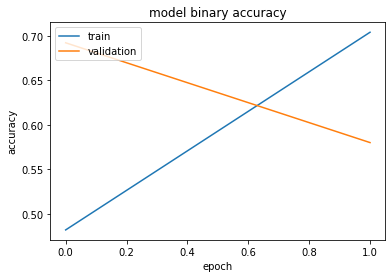

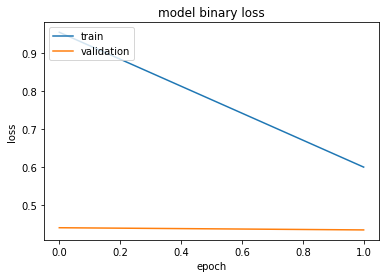

In [22]:
# modelB
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(historyB.history['accuracy'])
plt.plot(historyB.history['val_accuracy'])
plt.title('model binary accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('model binary loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# modelC
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(historyC.history['accuracy'])
plt.plot(historyC.history['val_accuracy'])
plt.title('model categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyC.history['loss'])
plt.plot(historyC.history['val_loss'])
plt.title('model categorical loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### Prediction
* Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [23]:
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import math 
# re-initialize our testing data generator, this time for evaluating
img_seq_gen_test = ImageSequenceGenerator()
testGen = img_seq_gen_test.png_image_generator(path, bs=BS, mode="test", difficulty=difficulty, label_type = label_type, aug=None)

# label with the corresponding predicted PROBABILITYs for each class e.g. [0.4, 0.7, 0.2]
predict_prob = model.predict(x=testGen, steps=(NUM_TEST_SEQ // BS) + 1)
print('predicted probability:\n',predict_prob[0:4])
# convert probabilities to binary, with given threshold  e.g. [0,1,0]
threshold = 0.5
Y_predict_binary = np.where(predict_prob > threshold, 1, 0)
print('predictions:\n', Y_predict_binary[0:4])
print('true labels:\n', Y_test_binary[0:4])

# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(Y_test_binary, Y_predict_binary, target_names=['B','L','R']))

predicted probability:
 [[0.5152317  0.34639373 0.13837449]
 [0.5152317  0.34639373 0.13837449]
 [0.5152317  0.34639373 0.13837449]
 [0.5152317  0.34639373 0.13837449]]
predictions:
 [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
true labels:
 [[1 1 0]
 [1 1 0]
 [1 0 0]
 [0 0 1]]
[INFO] evaluating network...
              precision    recall  f1-score   support

           B       0.68      1.00      0.81        65
           L       0.00      0.00      0.00        35
           R       0.00      0.00      0.00        27

   micro avg       0.68      0.51      0.58       127
   macro avg       0.23      0.33      0.27       127
weighted avg       0.35      0.51      0.41       127
 samples avg       0.68      0.51      0.56       127

